<a href="https://colab.research.google.com/github/natbcar/MachineLearning/blob/main/kmeans_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# JAX: Autograd and XLA


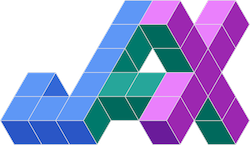

Jax is autograd and XLA combined to make a super fast and efficent programming language by enabling GPU and TPU acceleration. It also allows composable function transformations in python. I'll show a few features and demonstrate the performance benifits of numpy GPU acceleration on the kmeans clustering.

In [3]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap, random, partial
from jax.ops import index, index_add, index_update
from sklearn import datasets
from sklearn.datasets import make_blobs
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import time

# K-means Clustering in Numpy

The goal of clustering is to partition $n$ data points into $k$ clusters or groups. The algorithm is suprisingly simple.

1) Randomly initialize $k$ centroids or clusters \\
2) For each data point compute the euclidean distance from it to each of the $k$ clusters and assign it to the one it is closest to \\
3) Update the centroids as the geometric mean of the feature vectors assigned to it \\
4) Repeat 2 & 3 until the clusters stop changing or your algorithm has ran for the maximum ammount of
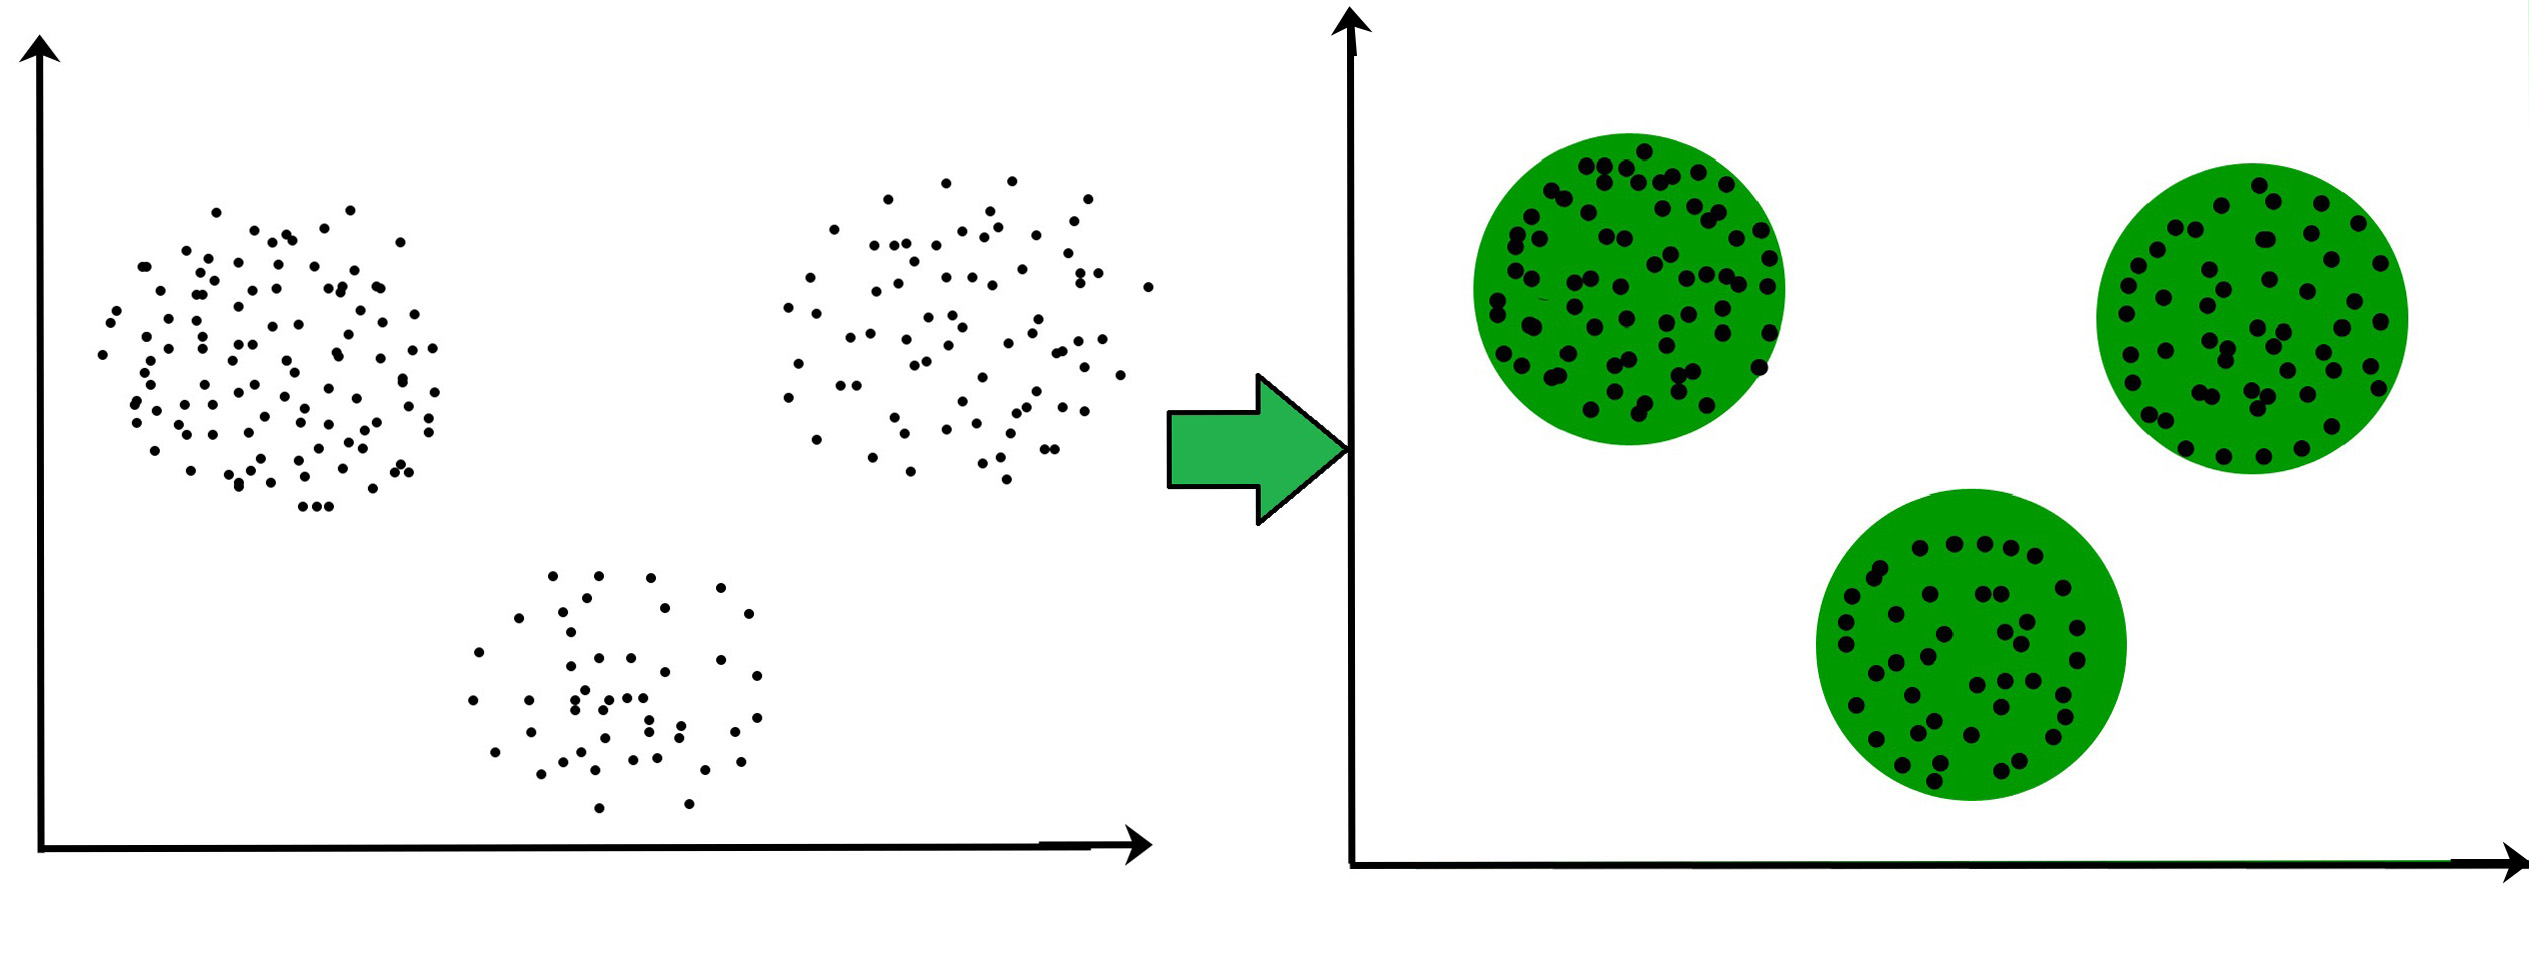


In [4]:
def np_kmeans(X, k, max_iter, tol=1e-10):
  """
  performs kmeans clustering on a set of data samples partitioning them into k
  distinct groups or clusters
  X (array) : n x d array of training data where n is number of examples and 
  d is the dimension 
  k (int) : number of clusters
  max_iter (int) : max number of iterations
  tol (float) : stopping tolerance
  """
  def get_assignments(centroids, n):
    "Computes cluster assignments for all features with given centroids"
    distances = np.zeros((n, k))
    for i in range(n):
      distances[i, :] = np.linalg.norm((X[i, :] - centroids), ord=2, axis=1)
    return np.argmin(distances, axis=1)

  def update_centroids(centroids, n, d):
    "Updates the cluster centers"
    assignments = get_assignments(centroids, n)
    new_centroids = np.zeros((k, d))
    for j in range(k):
      current_cluster = X[assignments == j]
      if len(current_cluster) == 0:
        new_centroids[j, :] = np.random.randn(1, d)
      else:
        new_centroids[j, :] = np.sum(current_cluster, axis=0) / current_cluster.shape[0]
    return new_centroids, assignments, ((new_centroids - centroids) > tol).any()

    
  n, d = X.shape  # number of training examples, dimension of features 
  centroids = np.random.randn(k, d)  # centroids k x d
  centroids, assignments, keep_going = update_centroids(centroids, n, d)  # initial update

  iter = 0
  while iter < max_iter and keep_going:
    centroids, assignments, keep_going = update_centroids(centroids, n, d)
    iter += 1

  return centroids, assignments, keep_going

In [5]:
# use sklearn make blobs functiont to generate data with gaussian blobs
X = np.array(make_blobs(500, 3, 5)[0])

In [6]:
clusters, assignments, keep_going = np_kmeans(X, 5, 100)

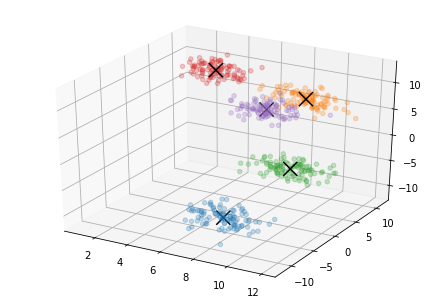

In [24]:
fig = plt.figure()
ax = Axes3D(fig)

for i in range(clusters.shape[0]):
  ax.scatter(X[assignments == i,0], X[assignments == i,1], X[assignments == i,2], alpha=0.25)
ax.scatter(clusters[:,0], clusters[:,1], clusters[:,2], s=200, marker='x', color='0', alpha=1)
plt.show()

# K-means Clustering with JAX
Lets implement the same algorithm now in JAX.  

In [8]:
@jit
def get_assignments(X, centroids):
  assignments = jax.vmap(
      lambda feat: jnp.argmin(jax.vmap(jnp.linalg.norm)(feat - centroids))
  )(X)
  distances = jax.vmap(jnp.linalg.norm)(centroids[assignments, :] - X)
  return assignments, distances

@partial(jit, static_argnums=(1,))
def jax_kmeans(X, k, tol=1e-10):
  
  def update_centroids(results):
    "Updates the cluster centers"
    centroids, prev_distances, _ = results
    assignments, distances = get_assignments(X, centroids)
    counts = (
        (assignments[jnp.newaxis, :] == jnp.arange(k)[:, jnp.newaxis])
        .sum(axis=1, keepdims=True).clip(a_min=1.)
        )
    new_centroids = jnp.sum(
        jnp.where(assignments[:, jnp.newaxis, jnp.newaxis] == jnp.arange(k)[jnp.newaxis, :, jnp.newaxis],
                  X[:, jnp.newaxis, :],
                  0,
        ),
        axis=0
    ) / counts
    return new_centroids, jnp.mean(distances), prev_distances

  def keep_running(results):
    return (results[2] - results[1]) > tol

  subkey, key = random.split(random.PRNGKey(0))
  indices = jax.random.permutation(subkey, jnp.arange(X.shape[0]))[:k]
  centroids = X[indices, :]
  results = update_centroids((centroids, jnp.inf, None))
  centroids, _, assignments = jax.lax.while_loop(
                               keep_running,
                               update_centroids,
                               results)
  assignments, _ = get_assignments(X, centroids)
  return centroids, assignments

In [9]:
# use sklearn make blobs functiont to generate data with gaussian blobs
X = jnp.array(make_blobs(500, 3, 5)[0])

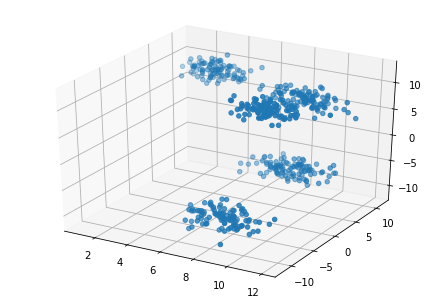

In [18]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X[:,0], X[:,1], X[:,2])
plt.show()

In [10]:
clusters, assignments = jax_kmeans(X, 5)

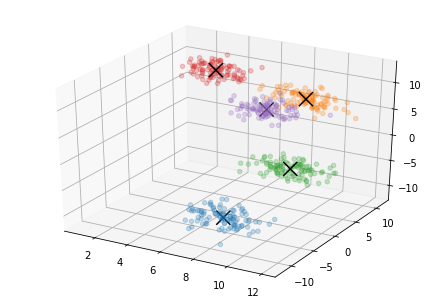

In [17]:
fig = plt.figure()
ax = Axes3D(fig)
for i in range(clusters.shape[0]):
  ax.scatter(X[assignments == i,0], X[assignments == i,1], X[assignments == i,2], alpha=0.25)
ax.scatter(clusters[:,0], clusters[:,1], clusters[:,2], s=200, marker='x', color='0', alpha=1)
plt.show()

# JAX vs. Numpy
Let's analyze the performance boosts that JAX provides with just in time (jit) compiling and XLA. 

In [34]:
# Time numpy clustering for increasing feature dimensions
cluster_dim = [2 ** i for i in range(20)]
np_times = []
for i in range(len(cluster_dim)):
  X = np.array(make_blobs(100, cluster_dim[i], 10)[0])
  start = time.time()
  np_kmeans(X, 10, 100)
  np_times.append(time.time() - start)

In [37]:
# Now lets do the same with JAX
cluster_dim = [2 ** i for i in range(20)]
jax_times = []
for i in range(len(cluster_dim)):
  X = jnp.array(make_blobs(100, cluster_dim[i], 10)[0])
  start = time.time()
  jax_kmeans(X, 10, 100)
  jax_times.append(time.time() - start)

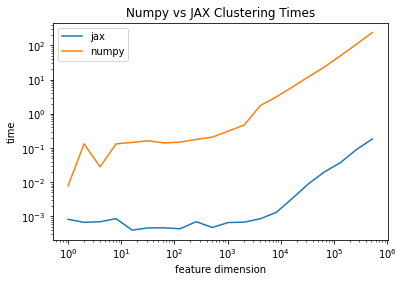

In [38]:
# It is clear JAX provides a speed boost when compared to numpy
plt.loglog(cluster_dim, jax_times, label='jax')
plt.loglog(cluster_dim, np_times, label='numpy')
plt.xlabel('feature dimension')
plt.ylabel('time')
plt.title('Numpy vs JAX Clustering Times')
plt.legend()
plt.show()